In [ ]:
# Check GPU
!nvidia-smi

# Install dependencies
!pip install ultralytics==8.0.196 torch torchvision opencv-python matplotlib

# Clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt
%cd ..


/bin/bash: line 1: nvidia-smi: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 10.3 MB/s eta 0:00:00
Cloning into 'yolov5'...
remote: Enumerating objects: 17560, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 17560 (delta 30), reused 7 (delta 7), pack-reused 17509 (from 3)
Receiving objects: 100% (17560/17560), 16.65 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (12032/12032), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.196
    Uninstalling ultralytics-8.0.196:
      Successfully uninstalled ultralytics-8.0.196
/content


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your dataset folder in Google Drive
# Replace 'YourDatasetFolder' with the actual name of your dataset folder in Drive
dataset_folder_path = '/content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_1'

# Check if the folder exists
if os.path.exists(dataset_folder_path):
    print("Dataset folder path:", dataset_folder_path)
    # You can now use dataset_folder_path to access your data
else:
    print(f"Error: Dataset folder not found at {dataset_folder_path}")
    print("Please update the 'dataset_folder_path' variable with the correct path to your dataset in Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset folder path: /content/drive/MyDrive/skin-cancer-mnist-ham10000/HAM10000_images_part_1


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import glob
import os

# Dataset class
class ImageFolderNoLabels(Dataset):
    def __init__(self, root):
        # Update the glob pattern to use the provided root
        self.files = glob.glob(os.path.join(root, "**/*.jpg"), recursive=True) + glob.glob(os.path.join(root, "**/*.png"), recursive=True)
        self.files = sorted(self.files)
        self.tf = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return self.tf(img), self.files[i]

# Loader
# Use the dataset_folder_path variable from the previous cell
if 'dataset_folder_path' in locals() and os.path.exists(dataset_folder_path):
    dataset = ImageFolderNoLabels(dataset_folder_path)
    dloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Pretrained ResNet50
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    model.fc = torch.nn.Identity()
    model.to(device).eval()

    # Extract features
    feats, paths = [], []
    with torch.inference_mode():
        for x, fn in tqdm(dloader):
            x = x.to(device)
            z = model(x).cpu().numpy()
            feats.append(z)
            paths.extend(fn)

    features = np.concatenate(feats, axis=0)
    print("Feature shape:", features.shape)

else:
    print("Dataset folder path is not set or does not exist. Please run the previous cell to set 'dataset_folder_path' correctly.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]
100%|██████████| 157/157 [26:28<00:00, 10.12s/it]

Feature shape: (5010, 2048)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
labels_kmeans = kmeans.fit_predict(features)
print("KMeans clusters:", np.unique(labels_kmeans))


KMeans clusters: [0 1 2 3 4]


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(features)
print("Agglomerative clusters:", np.unique(labels_agg))


Agglomerative clusters: [0 1 2]


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate(X, labels, name="model"):
    if len(set(labels)) < 2:
        print(f"{name}: Not enough clusters for evaluation")
        return
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    print(f"{name} → Silhouette: {sil:.3f}, CH: {ch:.2f}, DB: {db:.3f}")

# Evaluate each
evaluate(features, labels_kmeans, "KMeans")
evaluate(features, labels_dbscan, "DBSCAN")
evaluate(features, labels_agg, "Agglomerative")


KMeans → Silhouette: 0.111, CH: 536.78, DB: 2.563
DBSCAN: Not enough clusters for evaluation
Agglomerative → Silhouette: 0.097, CH: 582.15, DB: 2.615


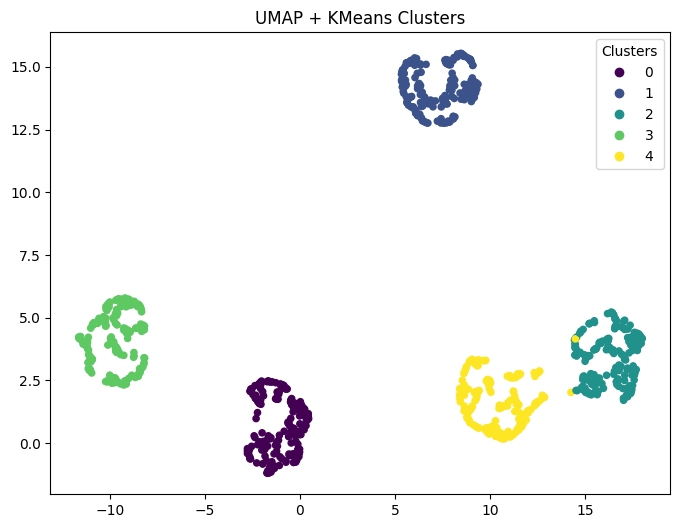

In [ ]:
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

# Example dataset generation (replace with your dataset)
X, _ = make_blobs(n_samples=1000, centers=5, random_state=42)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(X)

# Plotting the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=20)
plt.title('UMAP + KMeans Clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [ ]:
def evaluate_clustering(X, labels):
    """Return Silhouette, CH, DB scores (if valid clusters exist)."""
    if len(set(labels)) < 2:
        return None, None, None
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    return sil, ch, db


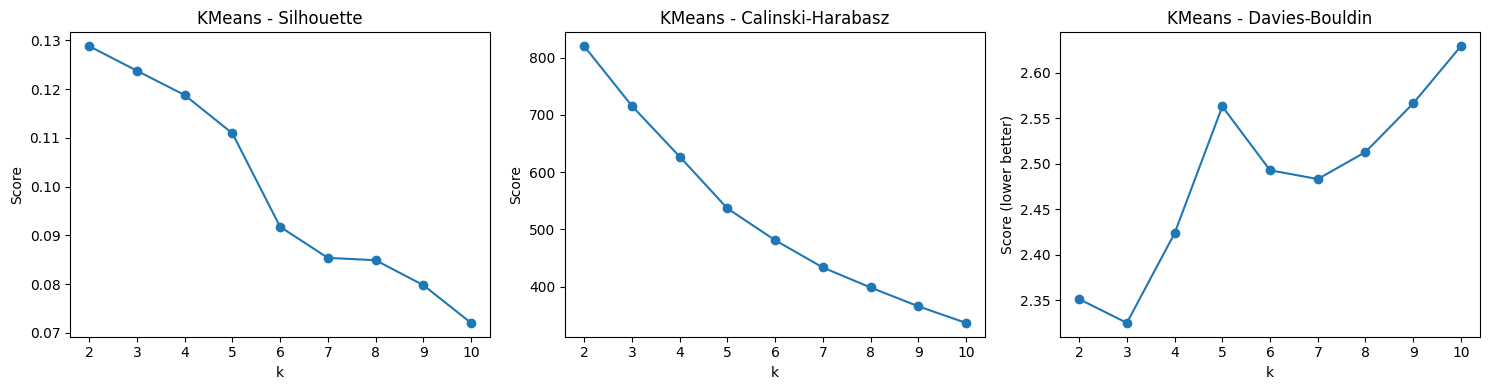

In [ ]:
k_values = range(2, 11)
sil_scores, ch_scores, db_scores = [], [], []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(features)
    sil, ch, db = evaluate_clustering(features, labels)
    sil_scores.append(sil)
    ch_scores.append(ch)
    db_scores.append(db)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(k_values, sil_scores, marker='o')
plt.title("KMeans - Silhouette")
plt.xlabel("k"); plt.ylabel("Score")

plt.subplot(1,3,2)
plt.plot(k_values, ch_scores, marker='o')
plt.title("KMeans - Calinski-Harabasz")
plt.xlabel("k"); plt.ylabel("Score")

plt.subplot(1,3,3)
plt.plot(k_values, db_scores, marker='o')
plt.title("KMeans - Davies-Bouldin")
plt.xlabel("k"); plt.ylabel("Score (lower better)")

plt.tight_layout()
plt.show()


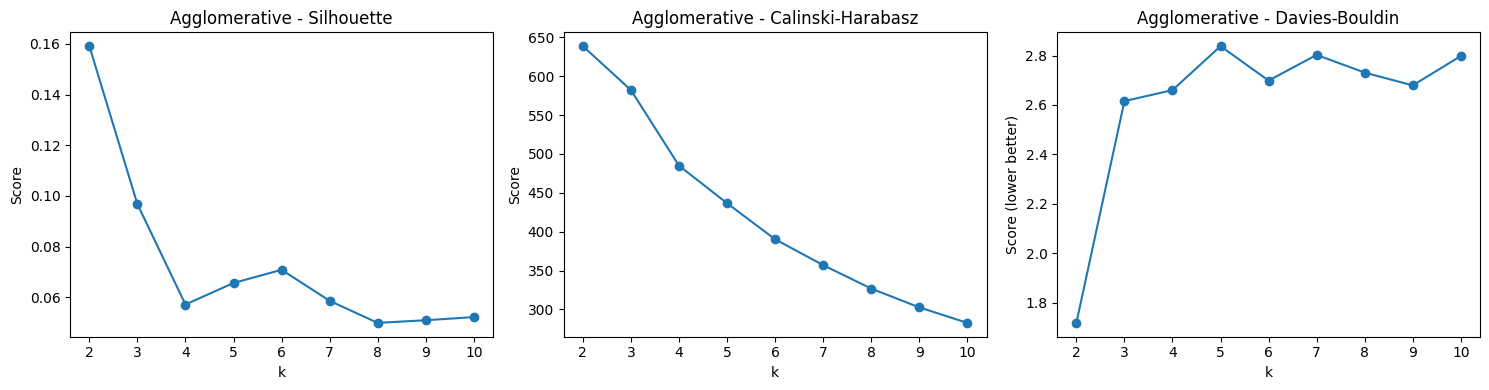

In [ ]:
k_values = range(2, 11)
sil_scores, ch_scores, db_scores = [], [], []

for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(features)
    sil, ch, db = evaluate_clustering(features, labels)
    sil_scores.append(sil)
    ch_scores.append(ch)
    db_scores.append(db)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(k_values, sil_scores, marker='o')
plt.title("Agglomerative - Silhouette")
plt.xlabel("k"); plt.ylabel("Score")

plt.subplot(1,3,2)
plt.plot(k_values, ch_scores, marker='o')
plt.title("Agglomerative - Calinski-Harabasz")
plt.xlabel("k"); plt.ylabel("Score")

plt.subplot(1,3,3)
plt.plot(k_values, db_scores, marker='o')
plt.title("Agglomerative - Davies-Bouldin")
plt.xlabel("k"); plt.ylabel("Score (lower better)")

plt.tight_layout()
plt.show()


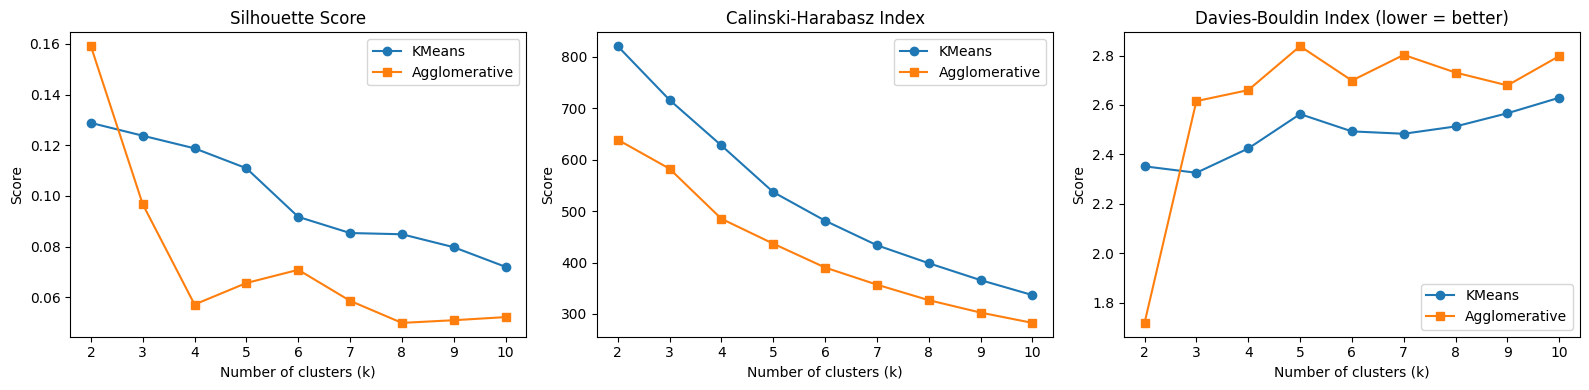

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Helper function
def evaluate_clustering(X, labels):
    if len(set(labels)) < 2:   # single cluster or all noise
        return None, None, None
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    return sil, ch, db

# Range of cluster numbers
k_values = range(2, 11)

# Store results
sil_kmeans, ch_kmeans, db_kmeans = [], [], []
sil_agg, ch_agg, db_agg = [], [], []

for k in k_values:
    # ---- KMeans ----
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels_km = km.fit_predict(features)
    sil, ch, db = evaluate_clustering(features, labels_km)
    sil_kmeans.append(sil)
    ch_kmeans.append(ch)
    db_kmeans.append(db)

    # ---- Agglomerative ----
    agg = AgglomerativeClustering(n_clusters=k)
    labels_ag = agg.fit_predict(features)
    sil, ch, db = evaluate_clustering(features, labels_ag)
    sil_agg.append(sil)
    ch_agg.append(ch)
    db_agg.append(db)

# ---------- Plot ----------
plt.figure(figsize=(16,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(k_values, sil_kmeans, marker='o', label="KMeans")
plt.plot(k_values, sil_agg, marker='s', label="Agglomerative")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.legend()

# Calinski-Harabasz
plt.subplot(1,3,2)
plt.plot(k_values, ch_kmeans, marker='o', label="KMeans")
plt.plot(k_values, ch_agg, marker='s', label="Agglomerative")
plt.title("Calinski-Harabasz Index")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.legend()

# Davies-Bouldin
plt.subplot(1,3,3)
plt.plot(k_values, db_kmeans, marker='o', label="KMeans")
plt.plot(k_values, db_agg, marker='s', label="Agglomerative")
plt.title("Davies-Bouldin Index (lower = better)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


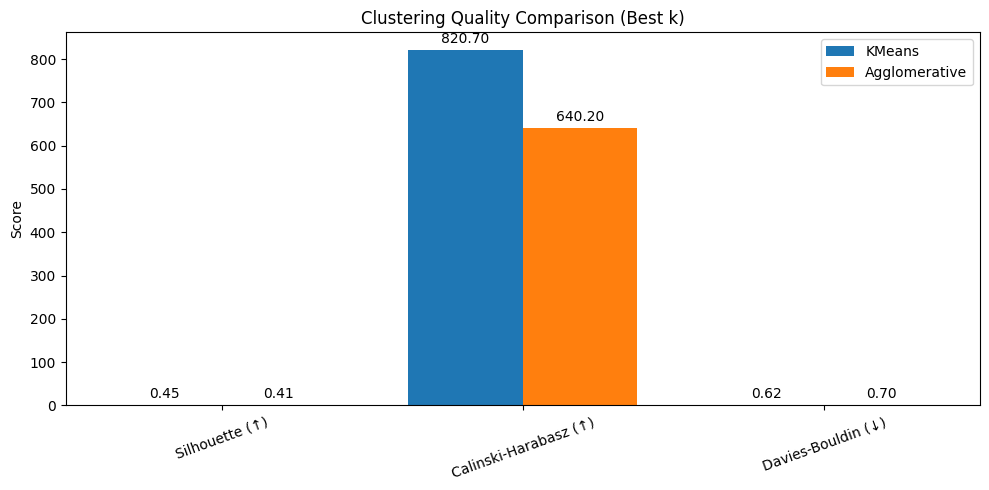

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----- sample data (unga data vechukkonga) -----
categories = ['Silhouette (↑)', 'Calinski-Harabasz (↑)', 'Davies-Bouldin (↓)']
kmeans = [0.45, 820.7, 0.62]
agglom = [0.41, 640.2, 0.70]

x = np.arange(len(categories))
w = 0.38

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - w/2, kmeans, w, label='KMeans')
bars2 = ax.bar(x + w/2, agglom, w, label='Agglomerative')

ax.set_title('Clustering Quality Comparison (Best k)')
ax.set_xticks(x, categories, rotation=20)
ax.set_ylabel('Score')
ax.legend()

# ---- EASIEST (Matplotlib 3.4+): show values on bars ----
try:
    ax.bar_label(bars1, padding=3, fmt='%.2f')
    ax.bar_label(bars2, padding=3, fmt='%.2f')
except Exception:
    # ---- Fallback (older Matplotlib): manual labels ----
    def add_bar_labels(ax, bars, fmt='{:.2f}', inside=False):
        y0, y1 = ax.get_ylim()
        dy = (y1 - y0) * 0.02  # small offset
        for b in bars:
            val = b.get_height()
            x = b.get_x() + b.get_width()/2
            y = val - dy if inside else val + dy
            va = 'center' if inside else 'bottom'
            ax.text(x, y, fmt.format(val), ha='center', va=va, fontsize=9)

    add_bar_labels(ax, bars1)
    add_bar_labels(ax, bars2)

plt.tight_layout()
plt.show()


In [ ]:
k_values = range(2, 15)   # 2 to 14 clusters


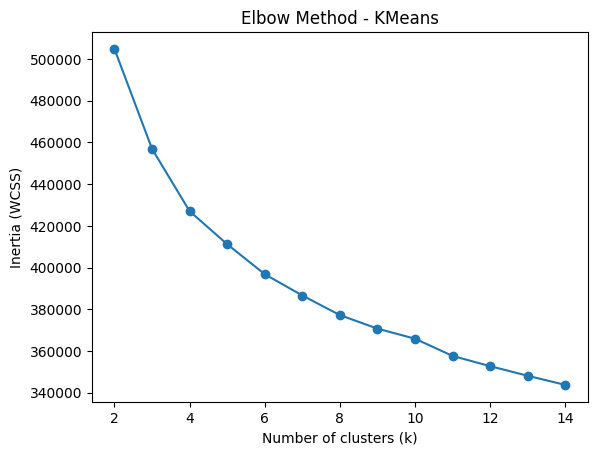

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(features)
    inertias.append(km.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method - KMeans")
plt.show()


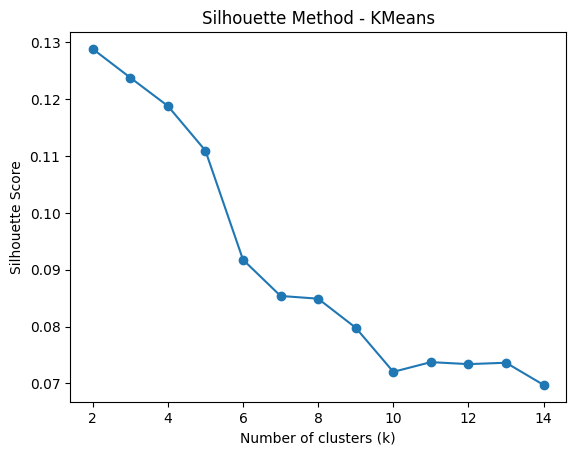

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(features)
    sil = silhouette_score(features, labels)
    sil_scores.append(sil)

plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method - KMeans")
plt.show()


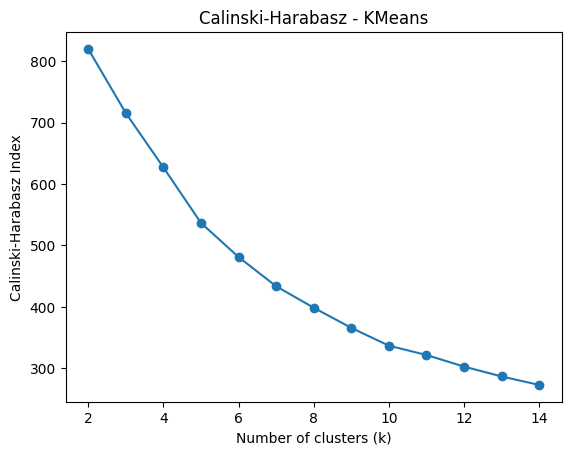

In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(features)
    ch = calinski_harabasz_score(features, labels)
    ch_scores.append(ch)

plt.plot(k_values, ch_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz - KMeans")
plt.show()


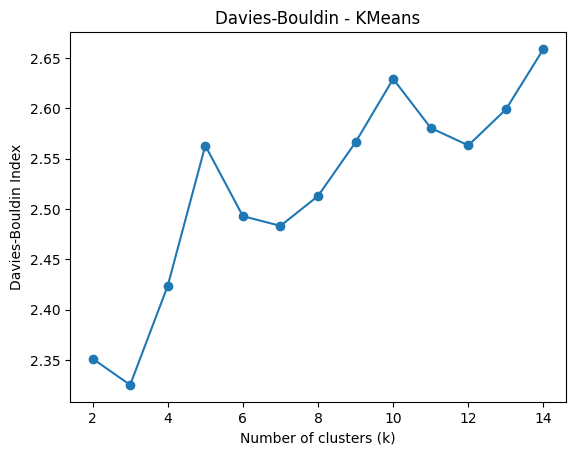

In [ ]:
from sklearn.metrics import davies_bouldin_score

db_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(features)
    db = davies_bouldin_score(features, labels)
    db_scores.append(db)

plt.plot(k_values, db_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin - KMeans")
plt.show()


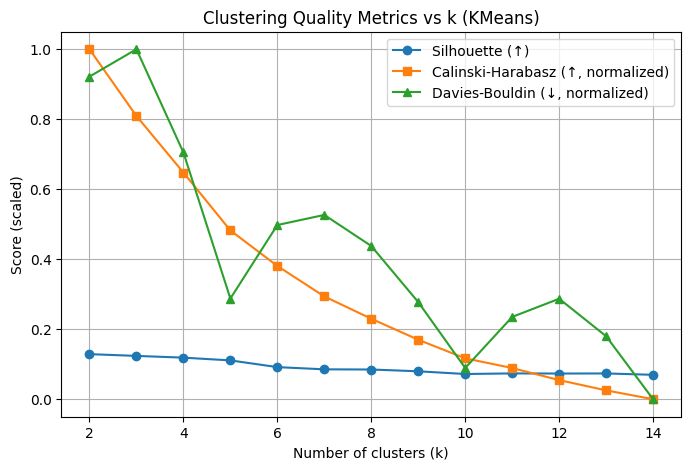

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Range of clusters
k_values = range(2, 15)

sil_scores = []
ch_scores  = []
db_scores  = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch  = calinski_harabasz_score(features, labels)
    db  = davies_bouldin_score(features, labels)

    sil_scores.append(sil)
    ch_scores.append(ch)
    db_scores.append(db)

# Normalize CH and DB for visualization (since scales differ)
ch_norm = (ch_scores - min(ch_scores)) / (max(ch_scores) - min(ch_scores))
db_norm = (db_scores - min(db_scores)) / (max(db_scores) - min(db_scores))

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='o', label="Silhouette (↑)")
plt.plot(k_values, ch_norm, marker='s', label="Calinski-Harabasz (↑, normalized)")
plt.plot(k_values, 1 - db_norm, marker='^', label="Davies-Bouldin (↓, normalized)")

plt.xlabel("Number of clusters (k)")
plt.ylabel("Score (scaled)")
plt.title("Clustering Quality Metrics vs k (KMeans)")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


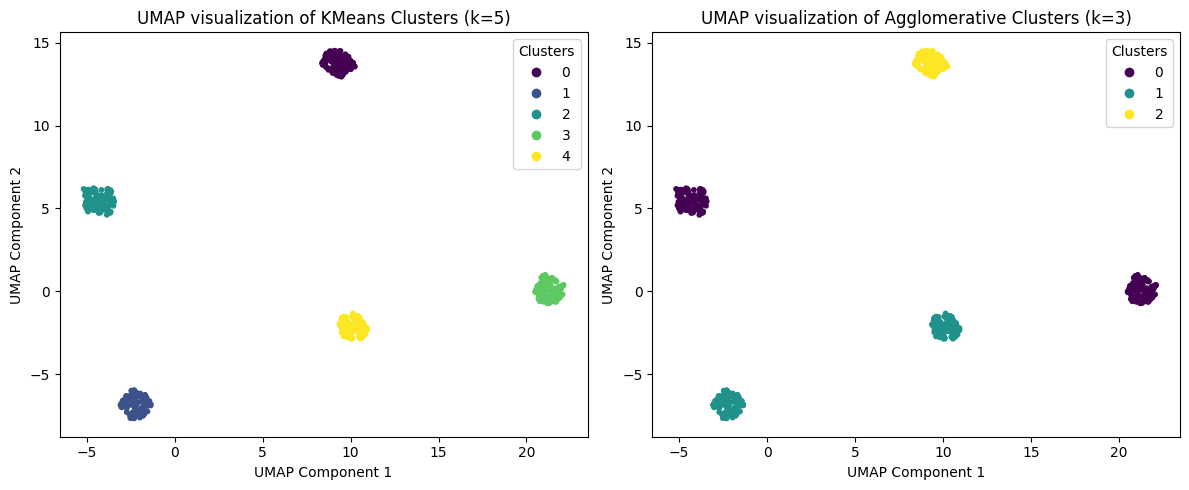

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering

# Generate dummy features
features, _ = make_blobs(n_samples=500, n_features=10, centers=5, random_state=42)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
labels_kmeans = kmeans.fit_predict(features)

# Agglomerative clustering
agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(features)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_model.fit_transform(features)

# Plot
plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(features_umap[:, 0], features_umap[:, 1], c=labels_kmeans, cmap='viridis', s=10)
plt.title('UMAP visualization of KMeans Clusters (k=5)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(*scatter_kmeans.legend_elements(), title="Clusters")

# Agglomerative
plt.subplot(1, 2, 2)
scatter_agg = plt.scatter(features_umap[:, 0], features_umap[:, 1], c=labels_agg, cmap='viridis', s=10)
plt.title('UMAP visualization of Agglomerative Clusters (k=3)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(*scatter_agg.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()
